# Heat and FW Fluxes

This file makes a figure for the paper to showcase heat and FW fluxes in the Easterlies experiment. In particular, we focus on the net FW fluxes from ice melting, which we show is the main control on DSW formation.

The simulations run from '2150-01-01' to '2164-12-31'

In [18]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import cftime
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36237,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:37813,Total threads: 4
Dashboard: /proxy/38999/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:45113,


In [3]:
# Using default database:
session = cc.database.create_session()

# List of simulations:
# Control
control = '01deg_jra55v13_ryf9091'
# 10% increase in easterly wind speed: WIND+
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed: WIND-
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
# 10% increase in easterly wind speed EXCEPT in DSW forming regions : WIND+_{NoDSW}
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
# 10% increase in ZONAL easterly wind speed: WIND+_{zonal}
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
# 10% increase in MERIDIONAL easterly wind speed: WIND+_{merid}
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'


# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-60)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht',session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [5]:
shelf_mask = np.squeeze(ht.values)*0
shelf_mask  = np.where(ht.values<1000,1, np.nan)
fontsize=16

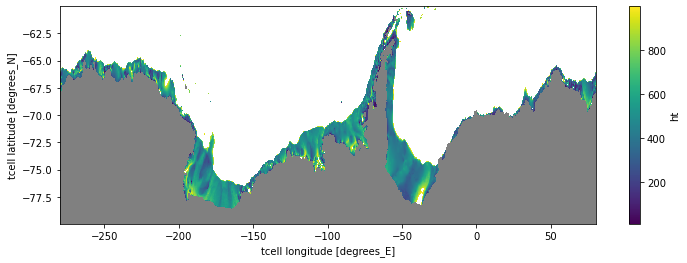

In [6]:
plt.figure(figsize=(12,4))
(ht*shelf_mask).plot()
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='gray')

In [7]:
area_t = cc.querying.getvar(control, 'area_t', session,n=1).load()
area_sum = (area_t.sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'}).load()
area_sum

<xarray.DataArray 'area_t' ()>
array(2.93965457e+12)

In [47]:
dbx = cc.explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

# Stuff I need to convert heat and FW fluxes to buoyancy fluxes

In [26]:
surface_temp = cc.querying.getvar(control, 'surface_temp', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SST = (surface_temp.mean('time').sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()
SST

<xarray.DataArray 'surface_temp' ()>
array(271.87653112)

In [32]:
st_ocean = cc.querying.getvar(control,'st_ocean',session,n=1)
depth = st_ocean[0].values
lat_t=-70
#depth_tile = (lat_t*0+1)*depth
#pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
pressure = p_from_z(depth_tile,lat_t)
pressure

-0.5468161884638841

In [33]:
surface_salt = cc.querying.getvar(control, 'surface_salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_PSU = (surface_salt.mean('time').sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()
# convert units to absolute salinity 
lon_t = 0
lat_t=-70
#SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
SSS = SA_from_SP(SSS_PSU,pressure,lon_t,lat_t)
SSS

<xarray.DataArray 'surface_salt' ()>
array(34.08769133)

In [34]:
#haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
haline_contraction = beta(SSS, SST, pressure)
haline_contraction

<xarray.DataArray 'surface_salt' ()>
array(0.00172851)

In [35]:
#thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
thermal_expansion = alpha(SSS, SST, pressure)
thermal_expansion

<xarray.DataArray 'surface_salt' ()>
array(0.02298535)

In [ ]:
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array

## Functions to calculate area-averaged fluxes:

This function calculates net surface heat flux
* The relevant heat flux terms are:

`heat flux = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme +sfc_hflux_from_runoff) + frazil_3d_int_z [calving=0?]`

where () terms are in net_sfc_heating.

Calculation is in W/m^2

In [8]:
def net_heat_flux(expt):
    swflx = cc.querying.getvar(expt, 'swflx', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    lw_heat = cc.querying.getvar(expt, 'lw_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sens_heat = cc.querying.getvar(expt, 'sens_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    evap_heat = cc.querying.getvar(expt, 'evap_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    fprec_melt_heat = cc.querying.getvar(expt, 'fprec_melt_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly',start_time=start_time, end_time=end_time)

    net_sfc_heating_ts = (((swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z)*area_t.sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/area_sum).load()
    return net_sfc_heating_ts

Function to calculate net FW flux, in kg/s/m^2.

* FW flux is given by:

`fwflux = (lprec + fprec + river + evap + melt) - (sfc_salt_flux_ice + sfc_salt_flux_restore)`

 -- for ice contribution we only need `(melt - sfc_salt_flux_ice)`

In [9]:
def net_fw_flux(expt):
    lprec = cc.querying.getvar(expt, 'lprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    fprec = cc.querying.getvar(expt, 'fprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    evap = cc.querying.getvar(expt, 'evap', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    river = cc.querying.getvar(expt, 'river', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    melt = cc.querying.getvar(expt, 'melt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly',start_time=start_time, end_time=end_time)

    net_sfc_fw_flux_ts = (((lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore)*area_t.sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/area_sum).load()
    return net_sfc_fw_flux_ts

We also sum total melt, in Sv, over the shelf area.

In [10]:
def total_melt(expt):
    #river = cc.querying.getvar(expt, 'river', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    melt = cc.querying.getvar(expt, 'melt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)

    #total_melt_ts = (((melt+river)*area_t.sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})).load()
    total_melt_ts = ((((melt)*area_t.sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'}))/1e9).load()
    return total_melt_ts

In [11]:
net_sfc_heat_control = net_heat_flux(control)
net_fw_flux_control = net_fw_flux(control)
total_melt_control = total_melt(control)

In [12]:
net_sfc_heat_up = net_heat_flux(easterlies_up)
net_fw_flux_up = net_fw_flux(easterlies_up)
total_melt_up = total_melt(easterlies_up)

In [13]:
net_sfc_heat_down = net_heat_flux(easterlies_down)
net_fw_flux_down = net_fw_flux(easterlies_down)
total_melt_down = total_melt(easterlies_down)

In [14]:
net_sfc_heat_up_noDSW = net_heat_flux(easterlies_up_noDSW)
net_fw_flux_up_noDSW = net_fw_flux(easterlies_up_noDSW)
total_melt_up_noDSW = total_melt(easterlies_up_noDSW)

In [15]:
net_sfc_heat_up_zonal = net_heat_flux(easterlies_up_zonal)
net_fw_flux_up_zonal = net_fw_flux(easterlies_up_zonal)
total_melt_up_zonal = total_melt(easterlies_up_zonal)

In [16]:
net_sfc_heat_up_meridional = net_heat_flux(easterlies_up_meridional)
net_fw_flux_up_meridional = net_fw_flux(easterlies_up_meridional)
total_melt_up_meridional = total_melt(easterlies_up_meridional)

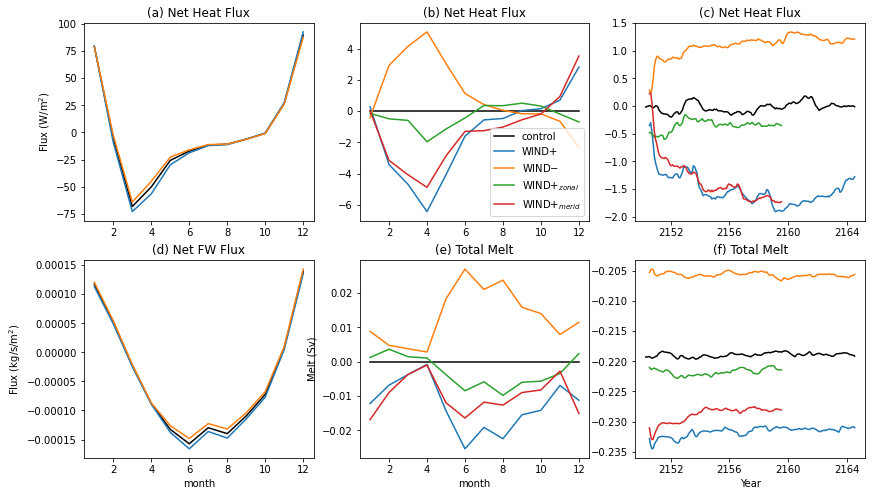

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(231)
net_sfc_heat_control.groupby('time.month').mean('time').plot(color='k',label='control')
net_sfc_heat_up.groupby('time.month').mean('time').plot(label='WIND+')
net_sfc_heat_down.groupby('time.month').mean('time').plot(label='WIND$-$')
plt.ylabel('Flux (W/m$^2$)')
plt.xlabel('')
plt.title('(a) Net Heat Flux')
#plt.legend()

plt.subplot(232)
climatology = net_sfc_heat_control.groupby('time.month').mean('time')
(climatology*0).plot(color='k',label='control')
(net_sfc_heat_up.groupby('time.month').mean('time')-climatology).plot(label='WIND+')
(net_sfc_heat_down.groupby('time.month').mean('time')-climatology).plot(label='WIND$-$')
(net_sfc_heat_up_zonal.groupby('time.month').mean('time')-climatology).plot(label='WIND+$_{zonal}$')
(net_sfc_heat_up_meridional.groupby('time.month').mean('time')-climatology).plot(label='WIND+$_{merid}$')
plt.title('(b) Net Heat Flux')
plt.xlabel('')
plt.legend()

plt.subplot(233)
net_sfc_heat_control.rolling(time=12, center=True).mean().plot(color='k',label='control')
net_sfc_heat_up.rolling(time=12, center=True).mean().plot(label='WIND+')
net_sfc_heat_down.rolling(time=12, center=True).mean().plot(label='WIND$-$')
net_sfc_heat_up_zonal.rolling(time=12, center=True).mean().plot(label='WIND+$_{zonal}$')
net_sfc_heat_up_meridional.rolling(time=12, center=True).mean().plot(label='WIND+$_{meridional}$')
plt.title('(c) Net Heat Flux')
plt.xlabel('')

plt.subplot(234)
net_fw_flux_control.groupby('time.month').mean('time').plot(color='k',label='control')
net_fw_flux_up.groupby('time.month').mean('time').plot(label='WIND+')
net_fw_flux_down.groupby('time.month').mean('time').plot(label='WIND$-$')
plt.title('(d) Net FW Flux')
plt.ylabel('Flux (kg/s/m$^2$)')
#plt.legend()

plt.subplot(235)
climatology = total_melt_control.groupby('time.month').mean('time')
(climatology*0).plot(color='k',label='control')
(total_melt_up.groupby('time.month').mean('time')-climatology).plot(label='WIND+')
#(total_melt_up_noDSW.groupby('time.month').mean('time')-climatology).plot(label='WIND+$_{NoDSW}$')
(total_melt_down.groupby('time.month').mean('time')-climatology).plot(label='WIND$-$')
(total_melt_up_zonal.groupby('time.month').mean('time')-climatology).plot(label='WIND+$_{zonal}$')
(total_melt_up_meridional.groupby('time.month').mean('time')-climatology).plot(label='WIND+$_{merid}$')
plt.ylabel('Melt (Sv)')
plt.title('(e) Total Melt')
#plt.legend()

plt.subplot(236)
total_melt_control.rolling(time=12, center=True).mean().plot(color='k',label='control')
total_melt_up.rolling(time=12, center=True).mean().plot(label='WIND+')
total_melt_down.rolling(time=12, center=True).mean().plot(label='WIND$-$')
total_melt_up_zonal.rolling(time=12, center=True).mean().plot(label='WIND+$_{zonal}$')
total_melt_up_meridional.rolling(time=12, center=True).mean().plot(label='WIND+$_{merid}$')
plt.title('(f) Total Melt')
plt.xlabel('Year')
#plt.legend()

plt.savefig('Figure5.png')

In [50]:
C_p = 3992.1

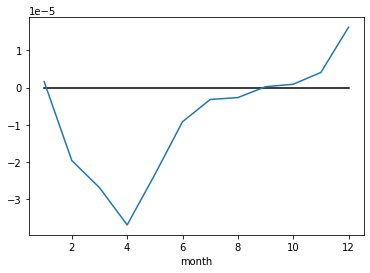

In [51]:
climatology = net_sfc_heat_control.groupby('time.month').mean('time')
(climatology*0).plot(color='k',label='control')
(thermal_expansion*(net_sfc_heat_up.groupby('time.month').mean('time')-climatology)/C_p).plot(label='WIND+')

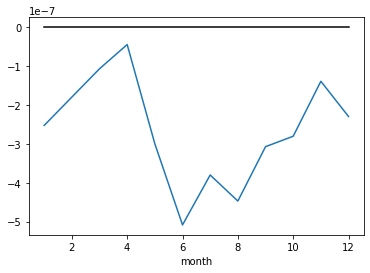

In [52]:
climatology = net_fw_flux_control.groupby('time.month').mean('time')
(climatology*0).plot(color='k',label='control')
(haline_contraction*(net_fw_flux_up.groupby('time.month').mean('time')-climatology)*SSS).plot(label='WIND+')

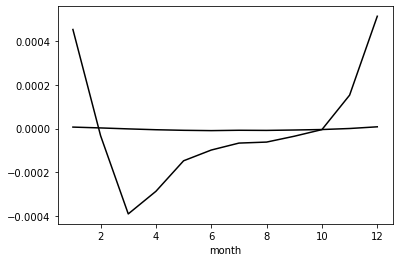

In [49]:
(thermal_expansion*net_sfc_heat_control/C_p).groupby('time.month').mean('time').plot(color='k',label='control')
(haline_contraction*net_fw_flux_control*SSS).groupby('time.month').mean('time').plot(color='k',label='control')

Text(0.5, 1.0, 'Freshwater')

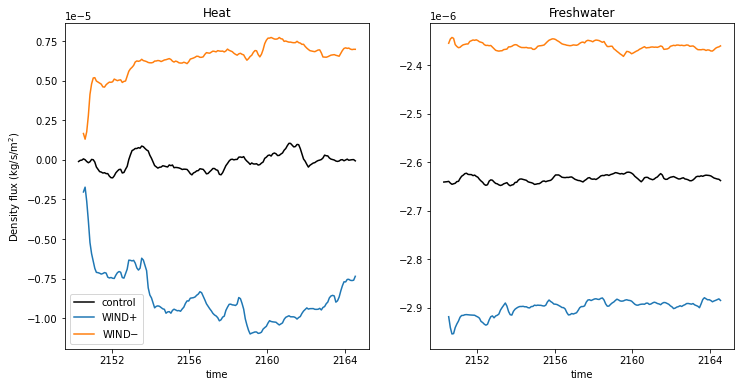

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(121)
(thermal_expansion*net_sfc_heat_control/C_p).rolling(time=12, center=True).mean().plot(color='k',label='control')
(thermal_expansion*net_sfc_heat_up/C_p).rolling(time=12, center=True).mean().plot(label='WIND+')
(thermal_expansion*net_sfc_heat_down/C_p).rolling(time=12, center=True).mean().plot(label='WIND$-$')
plt.title('Heat')
plt.ylabel('Density flux (kg/s/m$^2$)')
plt.legend()
plt.subplot(122)
(haline_contraction*net_fw_flux_control*SSS).rolling(time=12, center=True).mean().plot(color='k',label='control')
(haline_contraction*net_fw_flux_up*SSS).rolling(time=12, center=True).mean().plot(label='WIND+')
(haline_contraction*net_fw_flux_down*SSS).rolling(time=12, center=True).mean().plot(label='WIND$-$')
plt.title('Freshwater')

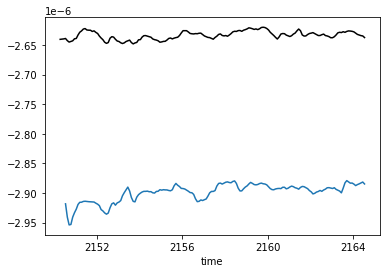